# Code Explanation

This script implements a **Maximum Likelihood Estimation (MLE)** approach for fitting a linear regression model. It performs estimation, statistical testing, and diagnostic analysis while providing detailed output and visualizations. Here's a breakdown of the main components:

## Imports
- **`numpy`**: For numerical operations and matrix manipulations.
- **`scipy.stats` and `scipy.optimize`**: For statistical functions and optimization routines.
- **`tabulate`**: Formats tables for text-based summaries.
- **`pandas`**: Handles input data manipulation when provided as a DataFrame.
- **`matplotlib.pyplot` and `seaborn`**: For creating diagnostic plots.

## `mle_model` Function
This function estimates regression coefficients using MLE and provides comprehensive model diagnostics.

### 1. **Data Preparation**
- Converts the input data (if it's a DataFrame) to a numpy array for computation.
- Ensures the dataset has at least two columns (dependent and independent variables).
- Constructs a design matrix (`X`) that includes an intercept term.

### 2. **Log-Likelihood Function**
- Defines the negative log-likelihood function based on the normal distribution.
- Assumes residuals follow a normal distribution with mean 0 and variance \(\sigma^2\).
- Includes the regression coefficients (`beta`) and the log-transformed standard deviation (`sigma`) as parameters.

### 3. **Parameter Estimation via Optimization**
- Initializes parameters with zeros for `beta` and the log of the standard deviation of `y`.
- Uses the **BFGS algorithm** to minimize the negative log-likelihood and obtain MLE estimates for `beta` and `sigma`.

### 4. **Model Diagnostics**
- Computes:
  - Residuals, fitted values, and mean squared error (MSE).
  - Standard errors of coefficients, t-values, and p-values for hypothesis testing.
  - \(R^2\) and adjusted \(R^2\) to measure model fit.
  - **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** for model comparison.
- Handles singular matrix issues gracefully with a fallback mechanism.

### 5. **Visual Diagnostics**
Generates four plots to assess model performance:
- **Residuals vs Fitted**: Evaluates heteroscedasticity and linearity.
- **Q-Q Plot**: Checks the normality of residuals.
- **Scale-Location Plot**: Examines the spread of residuals.
- **Residual Density Plot**: Visualizes the distribution of residuals.

### 6. **Output**
- Produces a summary report with coefficients, standard errors, t-values, and p-values in a table format.
- Provides key metrics like \(R^2\), log-likelihood, AIC, and BIC.
- Returns residuals, fitted values, and diagnostic plots for further analysis.
- Handles missing or non-computable statistics gracefully.

### 7. **Coefficient Table**
- Organizes the regression results into a neatly formatted table, including the following columns:
  - **Variable Name**: Names of predictors and intercept.
  - **Coefficient**: Estimated regression coefficients.
  - **Standard Error**: Variability of the estimates.
  - **t-value**: Test statistic for hypothesis testing.
  - **p-value**: Significance level of the estimates.

### Use Case
This function is ideal for scenarios where the assumption of normally distributed errors is valid, and MLE provides a robust framework for parameter estimation and model comparison.


In [1]:
import numpy as np
from scipy import stats, optimize
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def mle_model(data, feature_names=None):
    """
    Maximum Likelihood Estimation (MLE) for Linear Model
    """
    # Data preparation
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    if data.shape[1] < 2:
        raise ValueError("The data must contain at least two columns")
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    def log_likelihood(params):
        """Negative log-likelihood function"""
        beta = params[:-1].reshape(-1, 1)
        sigma = np.exp(params[-1])  # Ensure sigma is positive
        residuals = y - X @ beta
        ll = -0.5 * len(X) * np.log(2 * np.pi * sigma**2) - \
             (1 / (2 * sigma**2)) * np.sum(residuals**2)
        return -ll  # Return negative because we're minimizing
    
    # Initialize parameters (beta and log(sigma))
    init_params = np.zeros(X.shape[1] + 1)
    init_params[-1] = np.log(np.std(y))
    
    # Optimize using MLE
    mle_result = optimize.minimize(
        log_likelihood,
        init_params,
        method='BFGS',
        options={'disp': False}
    )
    
    # Extract results
    beta_mle = mle_result.x[:-1].reshape(-1, 1)
    sigma_mle = np.exp(mle_result.x[-1])
    log_lik = -mle_result.fun
    
    # Calculate standard errors using OLS approach
    y_hat = X @ beta_mle
    residuals = y - y_hat
    n = len(X)
    p = X.shape[1]
    
    # Calculate MSE
    mse = np.sum(residuals**2) / (n - p)
    
    # Calculate standard errors
    try:
        XtX_inv = np.linalg.inv(X.T @ X)
        se_beta_mle = np.sqrt(np.diag(XtX_inv * mse))
        
        # Calculate test statistics
        t_values = beta_mle.flatten() / se_beta_mle
        p_values = 2 * stats.t.sf(np.abs(t_values), df=n-p)
    except np.linalg.LinAlgError:
        print("Warning: Could not compute standard errors (singular matrix)")
        se_beta_mle = np.full(len(beta_mle), np.nan)
        t_values = np.full(len(beta_mle), np.nan)
        p_values = np.full(len(beta_mle), np.nan)
    
    # Calculate R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # Calculate AIC and BIC
    k = len(init_params)  # number of parameters (including sigma)
    aic = 2 * k - 2 * log_lik
    bic = np.log(n) * k - 2 * log_lik
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuals vs Fitted
    axes[0,0].scatter(y_hat.flatten(), residuals.flatten())
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Fitted values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('Residuals vs Fitted')
    
    # Q-Q plot
    stats.probplot(residuals.flatten(), dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Normal Q-Q Plot')
    
    # Scale-Location plot
    axes[1,0].scatter(y_hat.flatten(), np.sqrt(np.abs(residuals.flatten())))
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('√|Residuals|')
    axes[1,0].set_title('Scale-Location Plot')
    
    # Density plot of residuals
    sns.kdeplot(data=residuals.flatten(), ax=axes[1,1])
    axes[1,1].set_title('Residuals Density Plot')
    
    plt.tight_layout()
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta_mle)):
        coef_data.append([
            var_names[i],
            f"{beta_mle[i][0]:.4f}",
            f"{se_beta_mle[i]:.4f}",
            f"{t_values[i]:.4f}",
            f"{p_values[i]:.4f}"
        ])
    
    return {
        'summary': f"""
Maximum Likelihood Estimation Results
===================================
Dependent Variable: {feature_names[0]}
Number of Observations: {len(X)}
Number of Predictors: {X.shape[1]-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
Log-likelihood: {log_lik:.4f}
AIC: {aic:.4f}
BIC: {bic:.4f}
Sigma (MLE): {sigma_mle:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'log_likelihood': log_lik,
        'aic': aic,
        'bic': bic,
        'sigma': sigma_mle,
        'residuals': residuals.flatten(),
        'fitted_values': y_hat.flatten(),
        'diagnostic_plots': fig
    }




Maximum Likelihood Estimation Results
Dependent Variable: Y
Number of Observations: 200
Number of Predictors: 3

Model Statistics:
----------------
R-squared: 0.5968
Adjusted R-squared: 0.5906
Log-likelihood: -423.6626
AIC: 857.3253
BIC: 873.8169
Sigma (MLE): 2.0125

Coefficients:
------------
| Variable   |   Coefficient |   Std. Error |   t-value |   p-value |
|:-----------|--------------:|-------------:|----------:|----------:|
| Intercept  |        3.0376 |       0.1458 |   20.8353 |    0.0000 |
| X1         |        0.4523 |       0.1617 |    2.7980 |    0.0057 |
| X2         |       -0.8153 |       0.1440 |   -5.6620 |    0.0000 |
| X3         |        2.2371 |       0.1438 |   15.5591 |    0.0000 |



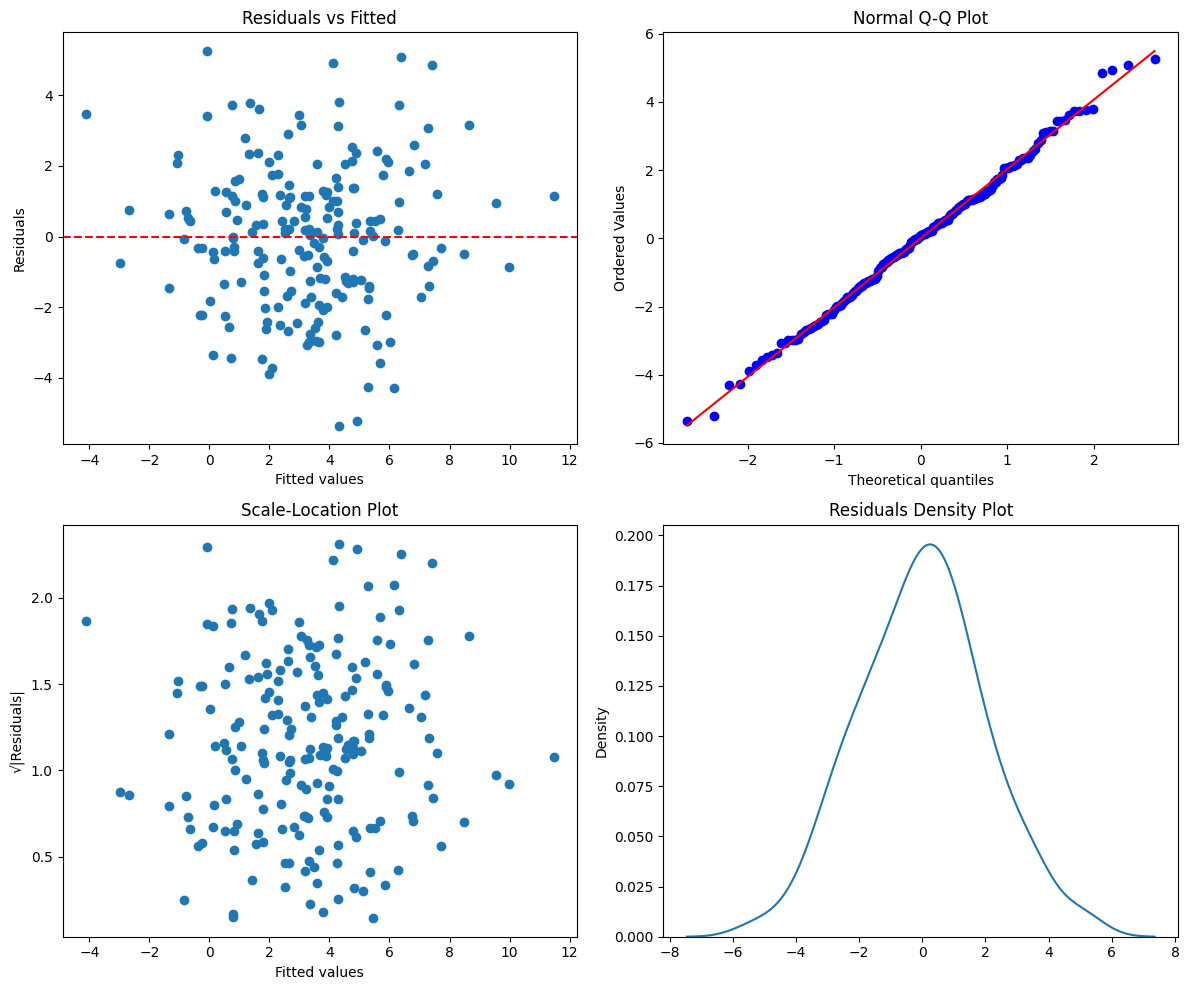

In [2]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    n = 200
    
    # True parameters
    beta_true = np.array([3, 0.5, -1, 2])
    sigma_true = 2
    
    # Generate predictors
    X = np.random.normal(0, 1, (n, 3))
    
    # Generate response with normal errors
    y = beta_true[0] + X @ beta_true[1:] + np.random.normal(0, sigma_true, n)
    
    # Create dataset
    data = np.column_stack([y, X])
    feature_names = ['Y', 'X1', 'X2', 'X3']
    
    # Fit model
    results = mle_model(data, feature_names)
    
    # Print results
    print(results['summary'])
    plt.show()